# House Prices - Advanced Regression Techniques (Top <1%)
I have tried to explain the steps in detail wherever posible. Please let me know in the comments if you have any questions. I'll try my best to follow up. 
This notebook was partly inspired by the [Feature Engineering for House Prices](https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices) notebook from instructors [Ryan Holbrook](https://www.kaggle.com/ryanholbrook) and [Alexis Cook](https://www.kaggle.com/alexisbcook) in their [Feature Engineering](https://www.kaggle.com/learn/feature-engineering) course for machine learning. 

# A. Load and Preprocess data
## Imports packages 

In [54]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import time

# Start counting notebook running time
time_start = time.time()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor

import optuna

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

sns.set()

## Import Data

In [55]:
data_dir = Path("../input/house-prices-advanced-regression-techniques/")

# Train data
df_train = pd.read_csv(data_dir / "train.csv", index_col="Id")
print(df_train.shape)

# Test data
df_test = pd.read_csv(data_dir / "test.csv", index_col="Id")
print(df_test.shape)

(1460, 80)
(1459, 79)


In [56]:
pd.set_option('display.max_columns', None) 
df_train.head(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [57]:
df_test.head(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal


### Merge train and test data

In [58]:
y = df_train.pop('SalePrice')
df_merged = pd.concat([df_train, df_test])
print(df_merged.shape)

(2919, 79)


### Check missing values (in percentage)

<AxesSubplot:ylabel='Missing values (%)'>

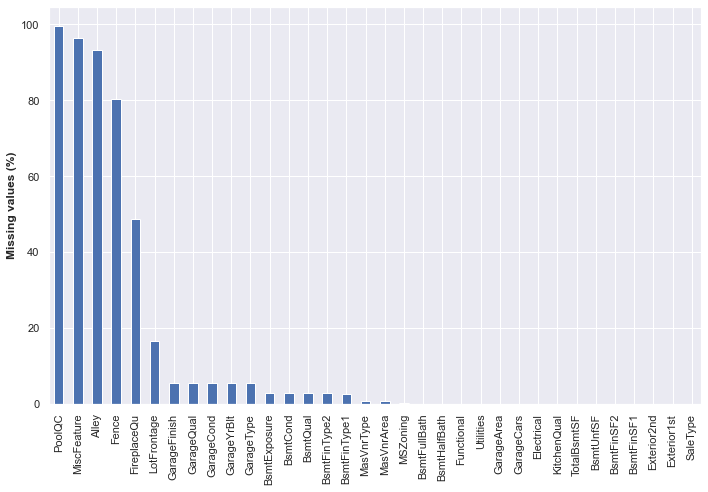

In [59]:
df_missing = df_merged.isna().sum()[df_merged.isna().sum() > 0].sort_values(ascending = False)/len(df_merged)*100
df_missing.plot.bar(figsize = (10,7), ylabel = 'Missing values (%)')

## Clean Data

Some of the categorical features in this dataset have what are apparently typos in their categories (as we compare them to the information in data_description.txt):

In [60]:
# Construction year of the newest house
df_merged.YearBuilt.max() # 2010

def clean(df):
    
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    
    # Some values of GarageYrBlt are corrupt, so we'll replace them with the year the house was built
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    
    # Some values of YrSold are also corrupt i.e. house was sold before it was built! We'll replace them with the year the house was built
    df["YrSold"] = df["YrSold"].where(df.YrSold >= df.YearBuilt, df.YearBuilt)
    
    # Names beginning with numbers are awkward to work with
    df.rename(columns={"1stFlrSF": "FirstFlrSF",
                       "2ndFlrSF": "SecondFlrSF",
                       "3SsnPorch": "Threeseasonporch"},
              inplace=True)
    
    return df


df_merged = clean(df_merged)

## Statistical data types and missing values
### Encode ordered categorical features

In [61]:
# pandas calls the categories as "levels"
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"] # poor, fair, typical?, good, excellent
ten_levels = list(range(10))

ordered_levels = {
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# add a new level 'None' in each ordinal categorical feature so that we can replace NAs with a category 'None'.
ordered_levels = {key: ["None"] + value for key, value in ordered_levels.items()} 

def encode(df):
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels, ordered=True)) # changing data type to ordinal with (ordered  = True) 
    return df

# encode ordered categorical features
df_merged = encode(df_merged)


### Other encoding

In [62]:
# The 'MSSubClass' is a string/unordered(nominal) categorical variable but encoded as `int` type. So we need to convert the data type.  
df_merged['MSSubClass'] = df_merged.MSSubClass.astype('str')

### Handle Missing Values

In [63]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("O"):
        df[name] = df[name].fillna("None") # We made a new category 'None' during encoding so we can fill 'NA' with 'None'
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None") # We made a new category 'None' during encoding so we can fill 'NA' with 'None' 
        
    return df

# impute NAs
df_merged = impute(df_merged)

# Check if there are still NAs
df_merged.isna().sum()[df_merged.isna().sum() > 0].sort_values(ascending = False)


Series([], dtype: int64)

### Numeric features

In [64]:
numeric_features = []
for feature in df_merged.select_dtypes("number"):
    numeric_features.append(feature)
    
print('number of numeric features: ', len(numeric_features))

number of numeric features:  35


### Define a function for label encoding

In [65]:
def label_encode(df):
    X = df.copy()
    # The `cat.codes` attribute holds the category levels.
    for colname in X.select_dtypes(["category"]).columns:
        X[colname] = X[colname].cat.codes
    return X


### Define a function for one-hot encoding

In [66]:
def one_hot_encode(df):
    X = df.copy()
    X = pd.get_dummies(X, drop_first=True)
    return X

### Factorize ordered categorical features

In [67]:
df_merged = label_encode(df_merged)

### Check data types of all the features

In [68]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 79 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MSSubClass        2919 non-null   object 
 1   MSZoning          2919 non-null   object 
 2   LotFrontage       2919 non-null   float64
 3   LotArea           2919 non-null   int64  
 4   Street            2919 non-null   object 
 5   Alley             2919 non-null   object 
 6   LotShape          2919 non-null   int8   
 7   LandContour       2919 non-null   object 
 8   Utilities         2919 non-null   int8   
 9   LotConfig         2919 non-null   object 
 10  LandSlope         2919 non-null   int8   
 11  Neighborhood      2919 non-null   object 
 12  Condition1        2919 non-null   object 
 13  Condition2        2919 non-null   object 
 14  BldgType          2919 non-null   object 
 15  HouseStyle        2919 non-null   object 
 16  OverallQual       2919 non-null   int64  


As can be seen from the above information there are still some object/categorical data which we'll take care of later until we do some feature engineering with them! 

# B. Initial Analysis and Baseline Score

### Visualise the relation between numerical features and SalePrice

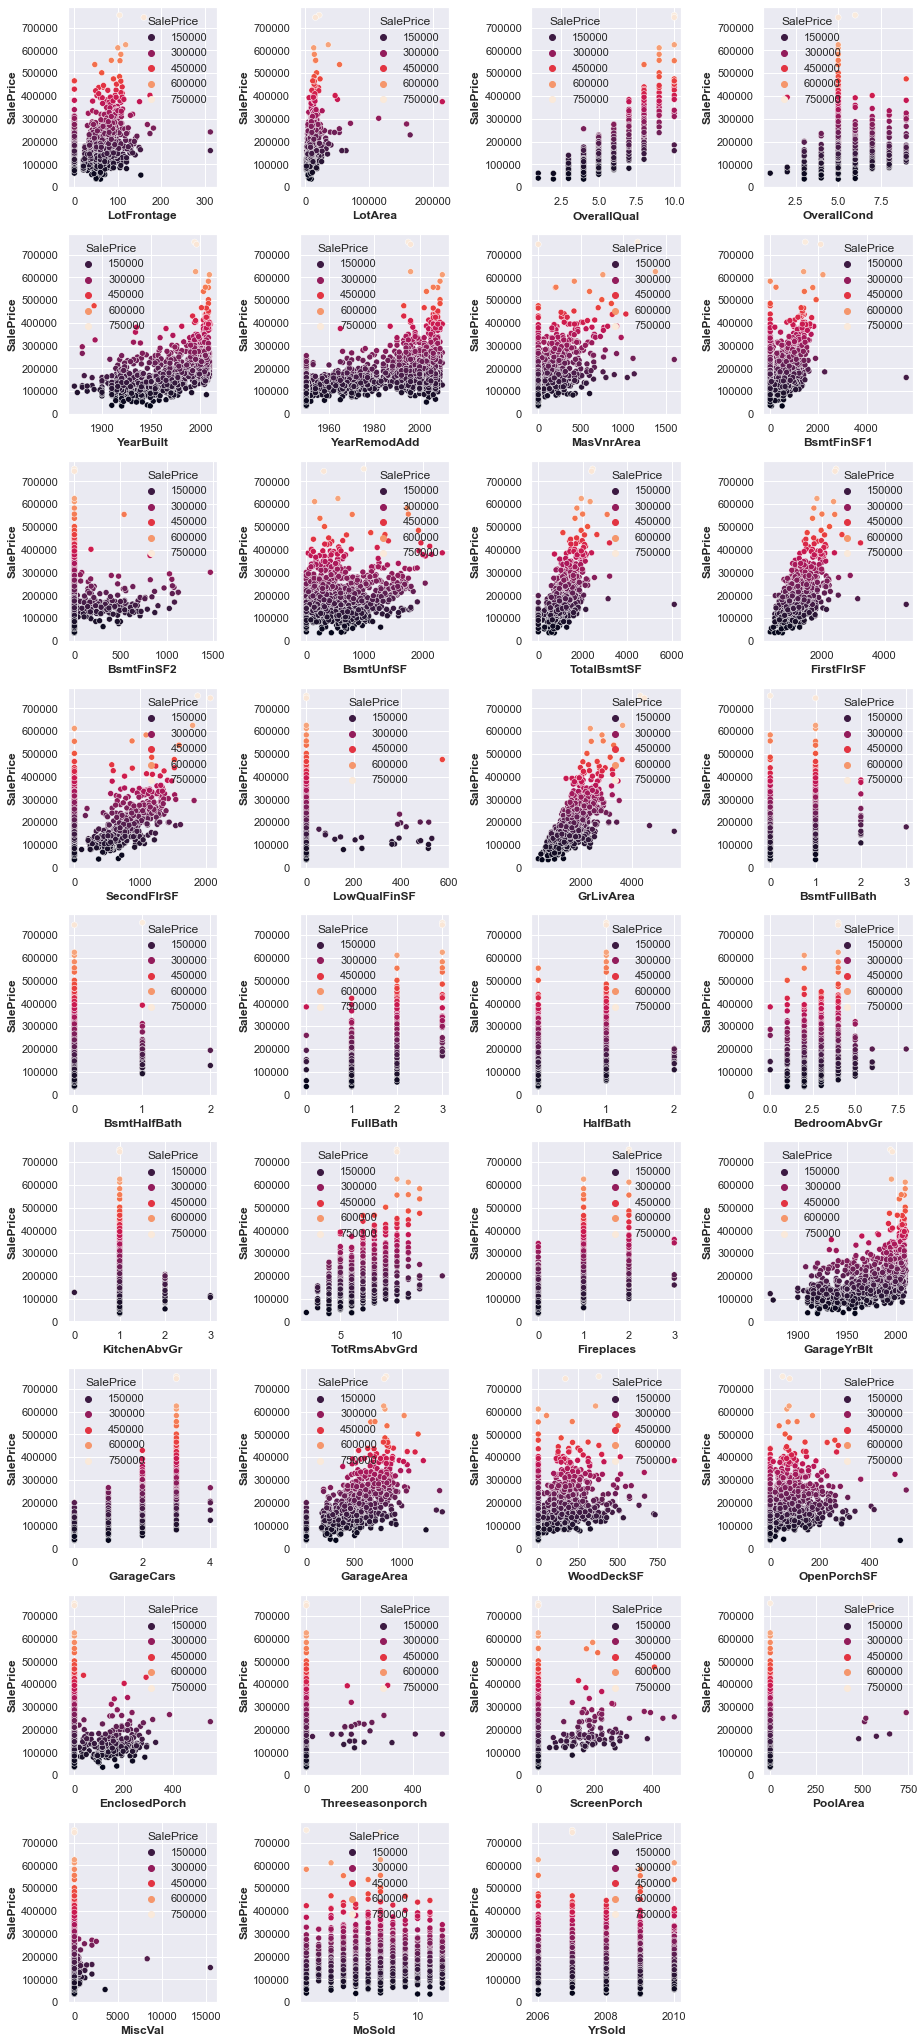

In [69]:
df_train = df_merged.loc[y.index, :]
df_train = df_train.join(y)

fig, axs = plt.subplots( figsize=(13, 110))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(len(numeric_features), 4, i)
    sns.scatterplot(x=col, y='SalePrice', hue='SalePrice', palette="rocket", data=df_train)

### Root Mean Squared Logaritmic Error (RMSLE)

In [70]:
# As the metric for loss is RMSLE, we need to log-transform y
def rmsle(X, y, model=XGBRegressor()):
    X = X.copy()
    X = pd.get_dummies(X, drop_first=True)
    score = -cross_val_score(model, X, np.log1p(y), cv=5, scoring="neg_mean_squared_error")
    score = score.mean()
    score = np.sqrt(score)
    return score

In [71]:
df_train = df_merged.loc[y.index, :]
df_train = df_train.join(y)
df_test = df_merged.loc[df_test.index, :]
print(df_train.shape)
print(df_test.shape)

(1460, 80)
(1459, 79)


In [72]:
%%time
X = df_train.copy()
y = X.pop("SalePrice")

baseline_score = rmsle(X, y)
print(f"Baseline score: {baseline_score:.5f} RMSLE")

Baseline score: 0.13858 RMSLE
CPU times: total: 8.64 s
Wall time: 4.01 s


This baseline score will help us to know the improvement of our predictions by further data processing and feature engineering. 

# C. Feature Engineering
Please check out the [Feature Engineering](https://www.kaggle.com/learn/feature-engineering) course from Kaggle for a great introduction. 

## Mutual Information Score

In [73]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes] 
    # defining all the integer (numeric) data types as discrete
    
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

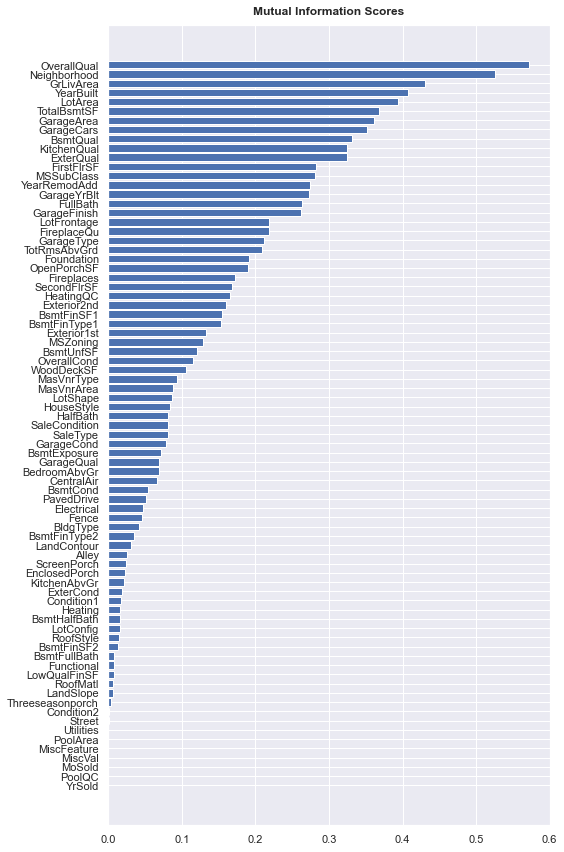

In [74]:
mi_scores = make_mi_scores(X, y) 
plt.figure(figsize=(8, 12))
plot_mi_scores(mi_scores)

The above plot gives us some insight on the mutual information between the target 'SalePrice' and the continuous and discrete features. 

## Interaction Features
Here we will investigate interactions between the features `GrLivArea`, `BldgType` and `Neighborhood`. While `GrLivArea` and `Neighborhood` scored highly in the MI scores, `BldgType` performed poorly. However, we should note that a feature (regardless has high or low MI score) can have interactions with other features and can thus be informative. It makes sense that the type of a dwelling and neighborhood should have effects on `GrLivArea` (Above ground living area) of the dwelling. We'll plot the variablitiy/trend of `SalePrice` for `GrLivArea` against different types of `BldgType` and `Neighborhood`. If there is significant variability in the `SalePrice` trend then there are interaction effects. We can include the interactions as new features in our model. 

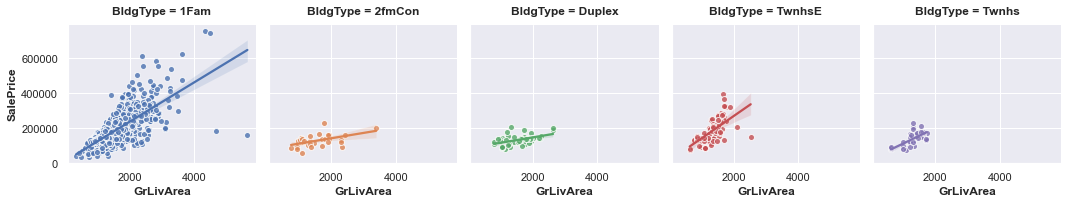

In [75]:
feature = "GrLivArea"

sns.lmplot(x=feature, y="SalePrice", hue="BldgType", col="BldgType",
           data=df_train, scatter_kws={"edgecolor": 'w'}, col_wrap=5, height=3);
plt.tight_layout()
plt.show()

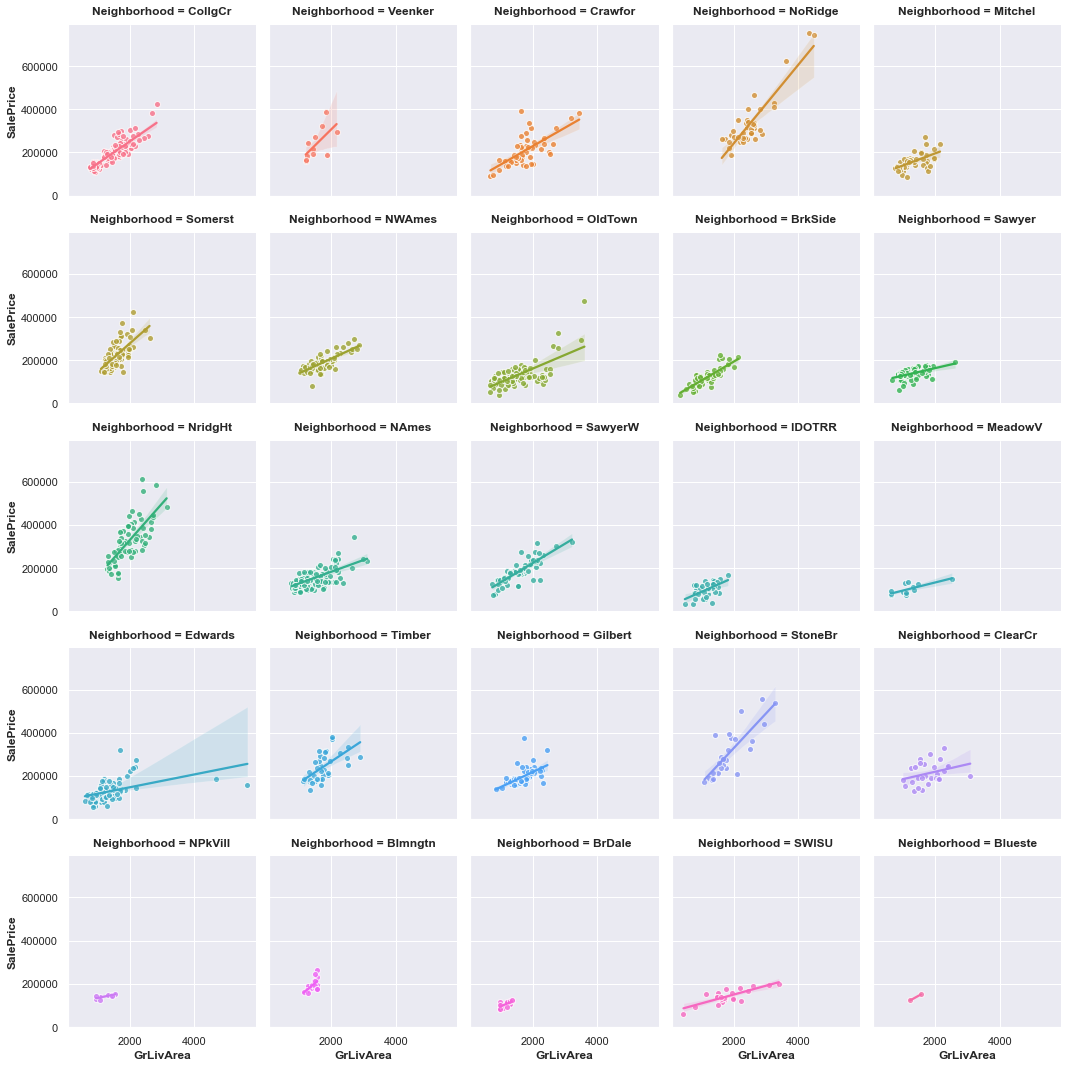

In [76]:
sns.lmplot(x=feature, y="SalePrice", hue="Neighborhood", col="Neighborhood",
           data=df_train, scatter_kws={"edgecolor": 'w'}, col_wrap=5, height=3);
plt.show()

## Create Features with Pandas
A lot of the features included in this section have been used by many of the Kaggle competition partitipants. I'm not sure who exactly should I give credit to. 
So my acknowlodgement to all of them :)

In [77]:
def create_features_pandas(df):
    
    X = df.copy()
    
    # mathematical_transforms:
    X["LivLotRatio"] = df.GrLivArea / df.LotArea
    X["Spaciousness"] = (df.FirstFlrSF + df.SecondFlrSF) / df.TotRmsAbvGrd
    X['NewHouse_RecentRemodel'] = 2*(df['YearBuilt']/2010) + (df['YearRemodAdd'] - df['YearBuilt'])/2010 
                                  # check the plot for 'SAlePrice' vs 'YearBuilt' and 'YearRemodAdd' in section B
        
    X['TotalSF'] = df['TotalBsmtSF'] + df['FirstFlrSF'] + df['SecondFlrSF'] 
    X['TotalSF2'] = df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['FirstFlrSF'] + df['SecondFlrSF']
    X['TotalBathrooms'] = df['FullBath'] + (0.5*df['HalfBath']) + df['BsmtFullBath'] + (0.5*df['BsmtHalfBath'])
    X['TotalPorchArea'] = df['OpenPorchSF'] + df['Threeseasonporch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF']
    
    X["OverallGrade"] = np.sqrt(df["OverallQual"] * df["OverallCond"])
    X["GarageGrade"] = np.sqrt(df["GarageQual"] * df["GarageCond"])
    X["ExterGrade"] = np.sqrt(df["ExterQual"] * df["ExterCond"])
    
    # special features
    X['HasPool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)                                                                          
    X['Has2ndfloor'] = df['SecondFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    X['HasGarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    X['HasBasement'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    X['HasFireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    X["HasShed"] = (df["MiscFeature"] == "Shed") * 1 
    X["RemodelbeforeSold"] = (df["YearRemodAdd"] == df["YrSold"])*1  # True(1) if a remodelling happened in the same year the house was sold
    
    X.loc[df.Neighborhood == 'NridgHt', "GoodNeighborhood"] = 1
    X.loc[df.Neighborhood == 'Crawfor', "GoodNeighborhood"] = 1
    X.loc[df.Neighborhood == 'StoneBr', "GoodNeighborhood"] = 1
    X.loc[df.Neighborhood == 'Somerst', "GoodNeighborhood"] = 1
    X.loc[df.Neighborhood == 'NoRidge', "GoodNeighborhood"] = 1
    X["GoodNeighborhood"].fillna(0, inplace=True)

    X["AbnormalSaleCondition"] = df.SaleCondition.replace({'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0}) 
    X["PartialSale"] = df.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1}) 
    X["GoodHeating"] = df.HeatingQC.replace({'Ex': 1, 'Gd': 1, 'TA': 0, 'Fa': 0, 'Po': 0})

    area_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                 'TotalBsmtSF', 'FirstFlrSF', 'SecondFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
                 'OpenPorchSF', 'EnclosedPorch', 'Threeseasonporch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea']
    X["TotalHouseArea"] = df[area_cols].sum(axis=1) 

    X["TotalArea1st2nd"] = df["FirstFlrSF"] + df["SecondFlrSF"]
    X["HouseAge"] = 2010 - df["YearBuilt"]
    X['SoldAge'] = df.YrSold - df.YearBuilt
       
    neighborhood = {"MeadowV" : 0,  "IDOTRR" : 1, "BrDale" : 1, "OldTown" : 1, "Edwards" : 1, "BrkSide" : 1, "Sawyer" : 1, 
                    "Blueste" : 1, "SWISU" : 2, "NAmes" : 2,  "NPkVill" : 2, "Mitchel" : 2, "SawyerW" : 2, "Gilbert" : 2, 
                    "NWAmes" : 2, "Blmngtn" : 2, "CollgCr" : 2, "ClearCr" : 3, "Crawfor" : 3, "Veenker" : 2, "Somerst" : 3, 
                    "Timber" : 3, "StoneBr" : 3, "NridgHt" : 3, "NoRidge" : 4}

    X["NeighborhoodMap"] = df["Neighborhood"].map(neighborhood)
    

    # logarithmic features from highly skewed features
    X["GrLivArea_log"] = np.log1p(df.GrLivArea)
    X['MasVnrArea_log'] = np.log1p(df.MasVnrArea)


    # interaction features
    X1 = pd.get_dummies(df.BldgType, prefix="BldgType_Interaction")
    X1 = X1.mul(df.GrLivArea, axis=0)
    
    X2 = pd.get_dummies(df.Neighborhood, prefix="Neighborhood_Interaction")
    X2 = X2.mul(df.GrLivArea, axis=0)
    
    X = X.join(X1)
    X = X.join(X2)

    
    # counts features
    X["PorchTypes"] = df[[
        "WoodDeckSF",
        "OpenPorchSF",
        "EnclosedPorch",
        "Threeseasonporch",
        "ScreenPorch",
    ]].gt(0.0).sum(axis=1)


    # group_transforms features
    X["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")
  
    return X


df_train = create_features_pandas(df_train)
df_test = create_features_pandas(df_test)

In [78]:
X = df_train.copy()
y = X.pop("SalePrice")

score = rmsle(X, y)
print(f"Score (CV): {score:.5f} RMSLE")

Score (CV): 0.13713 RMSLE


In [79]:
print(df_train.shape)
df_test.shape

(1460, 140)


(1459, 139)

## Additional Features from Principal Component Analysis (PCA)
PCA is an unsupervised machine learning technique that can be used for creating features. The PCA algorithm can decompose the variational structure within the features, give us loadings which describe each component of variation, and also the components which are the transformed datapoints. The loadings can suggest features to create and the components we can use as features directly. For further information please the [Feature Engineering](https://www.kaggle.com/learn/feature-engineering) course from Kaggle for machine learning .  

In [80]:
# Fit scikit-learn's PCA estimator and create the principal components
def apply_pca(X, standardize=True):
    # Standardize the data when the selected features aren't naturally on the same scale.
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


# Plot the variation captured by the the signs and magnitudes of a component's loadings
def plot_variance(pca):
    # Create figure
    fig, axs = plt.subplots(1, 2, figsize = (10, 5))
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.05))
    
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(xlabel="Component", title="% Cumulative Variance", ylim=(-0.02, 1.02))
    axs[0].set_ylim(0,1.05)
    # Set up figure
    return axs


In [81]:
pca_features = ['YearRemodAdd', 'TotalBsmtSF', 'GrLivArea']

X = df_train.copy()
X = X.loc[:, pca_features]

pca, X_pca, loadings = apply_pca(X)
loadings

,PC1,PC2,PC3
YearRemodAdd,0.506972,-0.861909,-0.009594
TotalBsmtSF,0.610309,0.351077,0.710118
GrLivArea,0.608689,0.365865,-0.704018


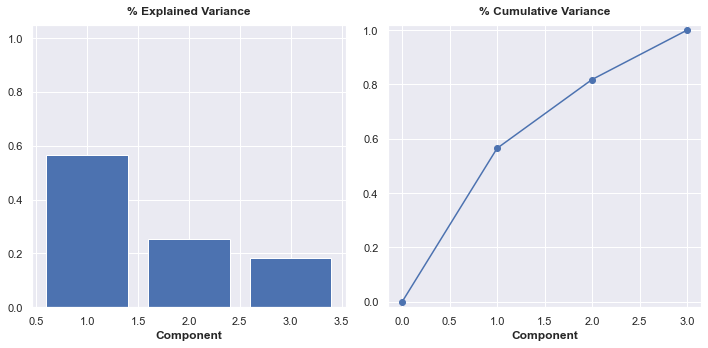

In [82]:
plot_variance(pca);

In [83]:
mi_scores = make_mi_scores(X_pca, y)
mi_scores

PC1    0.800267
PC3    0.340579
PC2    0.209341
Name: MI Scores, dtype: float64

**A correlation matrix for the dataset can help finding new features! We can search for highly correlated features and apply PCA.**

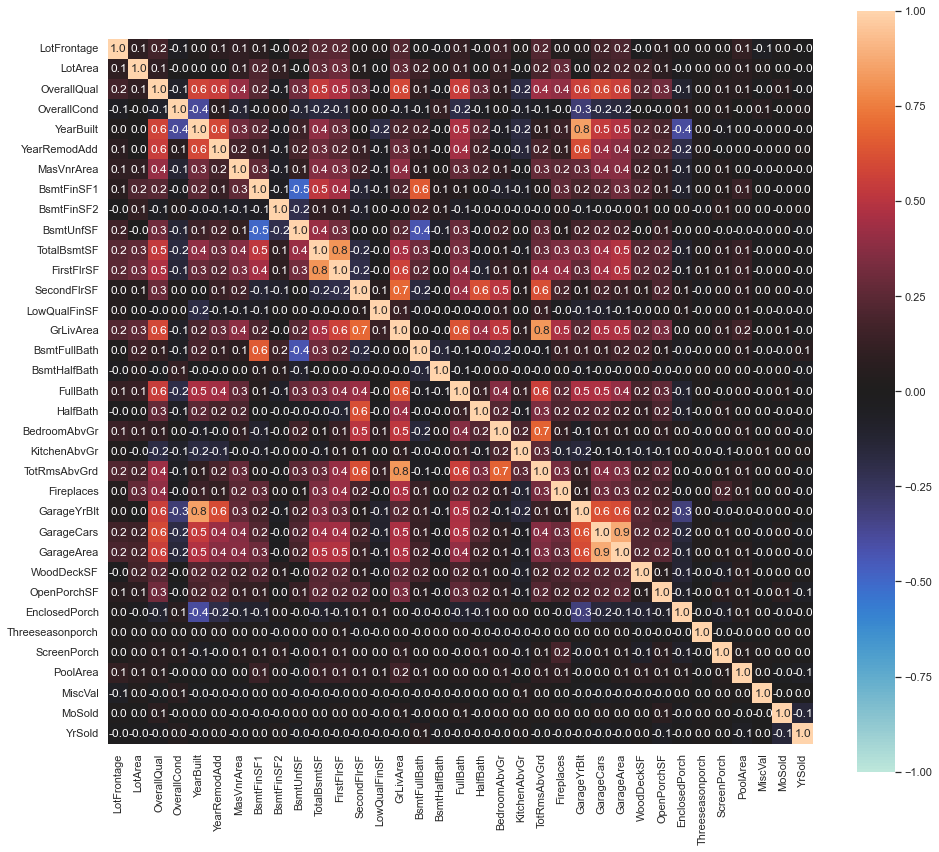

In [84]:
def corrplot(df, method="pearson"):
    corr = df.corr(method)
    plt.subplots(figsize=(14,12))
    sns.heatmap(corr, vmin=-1.0, vmax=1.0, cmap="icefire", square=True, annot=True, fmt=".1f") # cmap="Blues"   
    
X = df_train.copy()
y = X.pop("SalePrice")   
corrplot(X[numeric_features], method="pearson")

In [85]:
# Select highly correlated features as seen in the correlation plot and apply PCA 
pca_features2 = ['FullBath', 'FirstFlrSF', 'SecondFlrSF', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea', 'GrLivArea']

X = df_train.copy()
X = X.loc[:, pca_features2]

# `apply_pca`, defined above, reproduces the code from the tutorial
pca2, X_pca2, loadings2 = apply_pca(X)
loadings2

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
FullBath,0.388377,0.089598,0.057532,-0.909435,-0.036068,0.097151,0.003819
FirstFlrSF,0.310710,-0.420994,0.635974,0.110642,0.241857,-0.085545,-0.493666
SecondFlrSF,0.284178,0.612029,-0.321452,0.142251,0.329827,-0.034139,-0.557803
TotRmsAbvGrd,0.415006,0.290409,0.244309,0.261620,-0.779330,0.088544,-0.010238
GarageCars,0.379841,-0.372442,-0.463272,0.028345,-0.150992,-0.691836,0.012131
GarageArea,0.371316,-0.416292,-0.411836,0.164349,0.048228,0.699909,-0.002663
GrLivArea,0.466348,0.209301,0.212081,0.210219,0.446025,-0.075685,0.666990


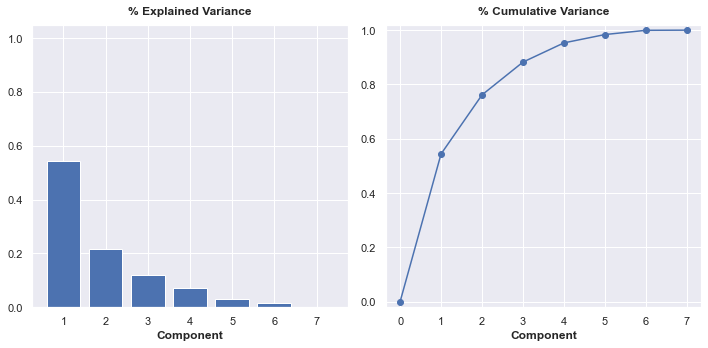

In [86]:
plot_variance(pca2);

In [87]:
mi_scores2 = make_mi_scores(X_pca2, y)
mi_scores2

PC1    0.667084
PC4    0.276402
PC2    0.227001
PC7    0.165142
PC6    0.054360
PC3    0.052895
PC5    0.052686
Name: MI Scores, dtype: float64

In [88]:
# Create New Features inspired by the loadings of the principal components
def pca_inspired(df):
    X = df.copy()
    X["Feature1"] = df.GrLivArea + df.TotalBsmtSF 
    X["Feature2"] = np.sqrt(df.YearRemodAdd * df.TotalBsmtSF)
    X["Feature3"] = df.GrLivArea * df.TotRmsAbvGrd 
    X["Feature4"] = np.sqrt(df.GrLivArea * df.FirstFlrSF)
    X["Feature5"] = np.sqrt(df.GarageCars * df.GarageArea)
    X["Feature6"] = np.sqrt(df.GrLivArea * df.FullBath)
    X["Feature7"] = np.sqrt(df.GrLivArea * df.SecondFlrSF)
   
    return X

df_train = pca_inspired(df_train)
df_test = pca_inspired(df_test)

X = df_train.copy()
y = X.pop("SalePrice")

score = rmsle(X, y)
print(f"Score (CV): {score:.5f} RMSLE")

Score (CV): 0.13562 RMSLE


# D. One hot encode all remaining non-numeric features
It's possible that not all the levels in a categorical feature of the training data will also be present in the same feature of the test data and vice versa. Hence, after one hot encoding we need to check if the number of features matches in train and teast data. Otherwise we'll need to do reindexing. 

In [89]:
df_train = one_hot_encode(df_train)
df_test = one_hot_encode(df_test)

In [90]:
print(df_train.shape)
df_test.shape

(1460, 280)


(1459, 270)

As the train and test data do not have the same number of features, we'll need to reindex test data according to train data.

In [91]:
X_train = df_train.copy()
y_train = X_train.pop("SalePrice")

X_test = df_test.copy()

In [92]:
# Reindex the features of the test data aligning with the training data
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [93]:
print(X_train.shape)
print(X_test.shape)

(1460, 279)
(1459, 279)


### Redifine the function for RMSLE

In [94]:
# As the categorical data are already one hot encoded, we do not need to encode again inside the function!
def rmsle(X, y, model=XGBRegressor()):
    X = X.copy()
    # X = pd.get_dummies(X, drop_first=True)
    score = -cross_val_score(model, X, np.log1p(y), cv=5, scoring="neg_mean_squared_error")
    score = score.mean()
    score = np.sqrt(score)
    return score

In [95]:
score = rmsle(X_train, y_train)
print(f"Score (CV): {score:.5f} RMSLE")

Score (CV): 0.13562 RMSLE


# E. Combine different models for improved prediction

### Hyperparameter Tuning
Hyperparameter tuning for XGB and Gradient Boosting Regressor was performed with Optuna. Please check the code below for your own hyperparameters search.

In [96]:
# # Optuna with XGBoost: Hyperparameter Tuning

# import optuna

# def objective(trial):
#     xgb_params = dict(
#         max_depth=trial.suggest_int("max_depth", 2, 10),
#         learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
#         n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
#         min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
#         colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
#         subsample=trial.suggest_float("subsample", 0.2, 1.0),
#         reg_alpha=trial.suggest_float("reg_alpha", 1e-3, 1, log=True),
#         reg_lambda=trial.suggest_float("reg_lambda", 1e-3, 1, log=True),
#     )
#     xgb = XGBRegressor(**xgb_params)
#     return rmsle(X_train, y_train, xgb)

# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=100)
# study.best_params


### XGB Regressor

In [97]:
# XGB Regressor
xgb_params = dict(max_depth=5,           
                  learning_rate=0.013272941370633515,    
                  n_estimators=1876,     
                  min_child_weight=1,    
                  colsample_bytree=0.2395378257765287,  
                  subsample= 0.7496307600223272,         
                  reg_alpha=0.02152634109282501,         
                  reg_lambda=0.06544801615179391,
                  random_state=1)

xgb =  XGBRegressor(**xgb_params)

### Gradient Boosting Regressor

In [98]:
# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=5211, 
                                learning_rate=0.009636280613755809, 
                                max_depth=4, 
                                max_features='sqrt', 
                                min_samples_leaf=5, 
                                min_samples_split=9, 
                                loss='huber', 
                                random_state=1)    

### Ridge

In [99]:
ridge = make_pipeline(RobustScaler(), Ridge(alpha = 6, 
                                            random_state=1))

### ElasticNet

In [100]:
elasticnet = make_pipeline(RobustScaler(), ElasticNet(max_iter=100000, 
                                                      alpha=0.0007, 
                                                      l1_ratio=0.9, 
                                                      random_state=1))

### Compare the score of the different models 

In [101]:
%%time

print('score comparison of all the models:')
score = rmsle(X_train, y_train, xgb)
print("xgb score: {:.5f}".format(score))

score = rmsle(X_train, y_train, gbr)
print("gbr score: {:.5f}".format(score))

score = rmsle(X_train, y_train, ridge)
print("ridge score: {:.5f}".format(score))

score = rmsle(X_train, y_train, elasticnet)
print("elasticnet score: {:.5f}".format(score))

score comparison of all the models:
xgb score: 0.11645
gbr score: 0.11734
ridge score: 0.12259
elasticnet score: 0.12069
CPU times: total: 3min 54s
Wall time: 2min 52s


### Fit each model to full training data

In [102]:
%%time

print('fitting started:')
xgb_model = xgb.fit(X_train, np.log(y_train))
print('xgb: done')

gbr_model = gbr.fit(X_train, np.log(y_train))
print('gbr: done')

ridge_model = ridge.fit(X_train, np.log(y_train))
print('ridge: done')

elastic_model = elasticnet.fit(X_train, np.log(y_train))
print('elasticnet: done')

fitting started:
xgb: done
gbr: done
ridge: done
elasticnet: done
CPU times: total: 51.5 s
Wall time: 34.6 s


### Define combined models for prediction

In [103]:
def combined_models(X):
    return ((0.35 * ridge_model.predict(X)) + 
            (0.1 * elastic_model.predict(X)) + 
            (0.25 * gbr_model.predict(X)) + 
            (0.3 * xgb_model.predict(X)))

### Make predictions and create submissions 

In [104]:
# As the y was log-transformed during fitting/training the model, we need to exp-transform the predictions
predictions = np.exp(combined_models(X_test))
output = pd.DataFrame({'Id': X_test.index, 'SalePrice': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")
print(output.head())

Your submission was successfully saved!
     Id      SalePrice
0  1461  120302.165273
1  1462  159202.812872
2  1463  184009.174035
3  1464  197651.659612
4  1465  188363.460090


In [106]:
time_end = time.time()
print("Notebook run time: {:.0f} seconds".format(time_end - time_start))

Notebook run time: 284 seconds
